In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer 
from sklearn.feature_selection import VarianceThreshold
import xgboost
from sklearn.model_selection import train_test_split
numerical_transformer = RobustScaler()

In [2]:
df = pd.read_csv('2/Base.csv')

In [ ]:
len(df)

In [ ]:
df.columns

In [ ]:
df.describe().transpose()

In [16]:
(df['fraud_bool'].value_counts() / len(df))*100

fraud_bool
0    98.8971
1     1.1029
Name: count, dtype: float64

In [ ]:
df.isnull().sum()

In [ ]:
df.dtypes

In [3]:
numerical = [feature for feature in df.columns if df[feature].nunique() >= 10]

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
fig.suptitle("Box Plots for Numerical Features")
for i, feature in enumerate(numerical):
    ax = axes[i//3][i%3]
    sns.boxplot(data=df, x='fraud_bool', y=feature, ax=ax)
    ax.set_xlabel('fraud_bool')
    ax.set_xticks([0, 1])
    ax.set_ylabel(feature)
    ax.set_xticklabels(['Not Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
fig.suptitle("KDE Plots for Numerical Features")
for i, feature in enumerate(numerical):
    ax = axes[i//3][i%3]
    sns.kdeplot(data=df[df['fraud_bool'] == 0][feature], fill=True, ax=ax, label='Not Fraud')
    sns.kdeplot(data=df[df['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraud')
    ax.set_xlabel(feature)
    ax.legend()
plt.tight_layout()
plt.show()

In [20]:
categorical = [feature for feature in df.columns if df[feature].dtype == 'object']

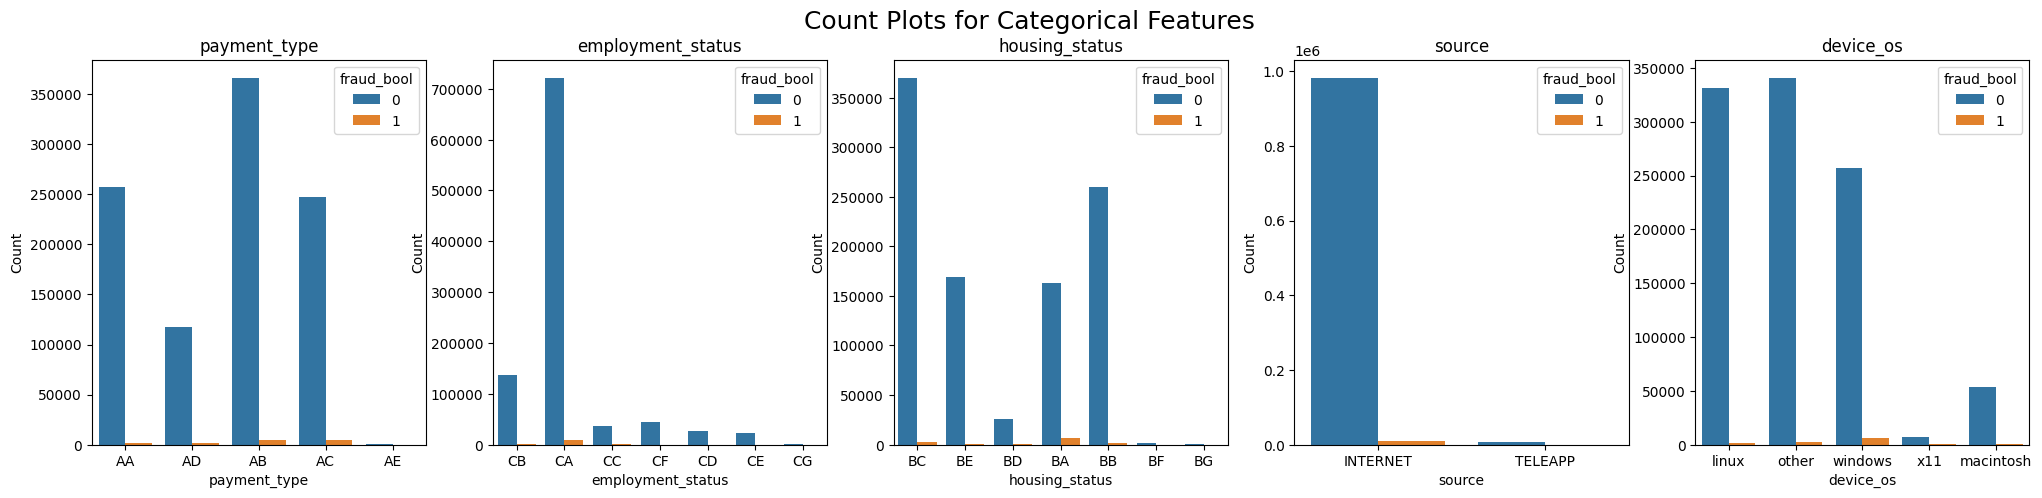

In [33]:
fig, axes = plt.subplots(nrows = 1, ncols=5, figsize=(25, 5))
fig.suptitle("Count Plots for Categorical Features", fontsize=18)
for i, feature in enumerate(categorical):
    sns.countplot(data=df, x=feature, hue="fraud_bool", ax=axes[i])
    axes[i].set_ylabel("Count")
    axes[i].set_title(f"{feature}")
plt.show()

In [34]:
new_df = df.copy()
new_df = pd.DataFrame(pd.get_dummies(new_df, prefix = categorical))
print(new_df.shape[1])

53


In [35]:
X = new_df.drop('fraud_bool', axis=1)
y = new_df['fraud_bool']

In [37]:
preprocessor = ColumnTransformer([('scaled', numerical_transformer, numerical)], remainder='passthrough')
X_scaled = preprocessor.fit_transform(X)

In [38]:
feature_names = preprocessor.get_feature_names_out()
feature_names = [feature.replace('remainder__', '') for feature in feature_names]
print(feature_names)

['scaled__name_email_similarity', 'scaled__prev_address_months_count', 'scaled__current_address_months_count', 'scaled__days_since_request', 'scaled__intended_balcon_amount', 'scaled__zip_count_4w', 'scaled__velocity_6h', 'scaled__velocity_24h', 'scaled__velocity_4w', 'scaled__bank_branch_count_8w', 'scaled__date_of_birth_distinct_emails_4w', 'scaled__credit_risk_score', 'scaled__bank_months_count', 'scaled__proposed_credit_limit', 'scaled__session_length_in_minutes', 'income', 'customer_age', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_B

In [39]:
X_scaled = pd.DataFrame(X_scaled, columns=feature_names)

In [45]:
selector = VarianceThreshold()
selector.fit(X_scaled)
constant_features = [feature for feature in X_scaled.columns 
                     if feature not in X_scaled.columns[selector.get_support()]]
print(constant_features)

['device_fraud_count']


In [47]:
df.drop('device_fraud_count', axis=1, inplace=True)

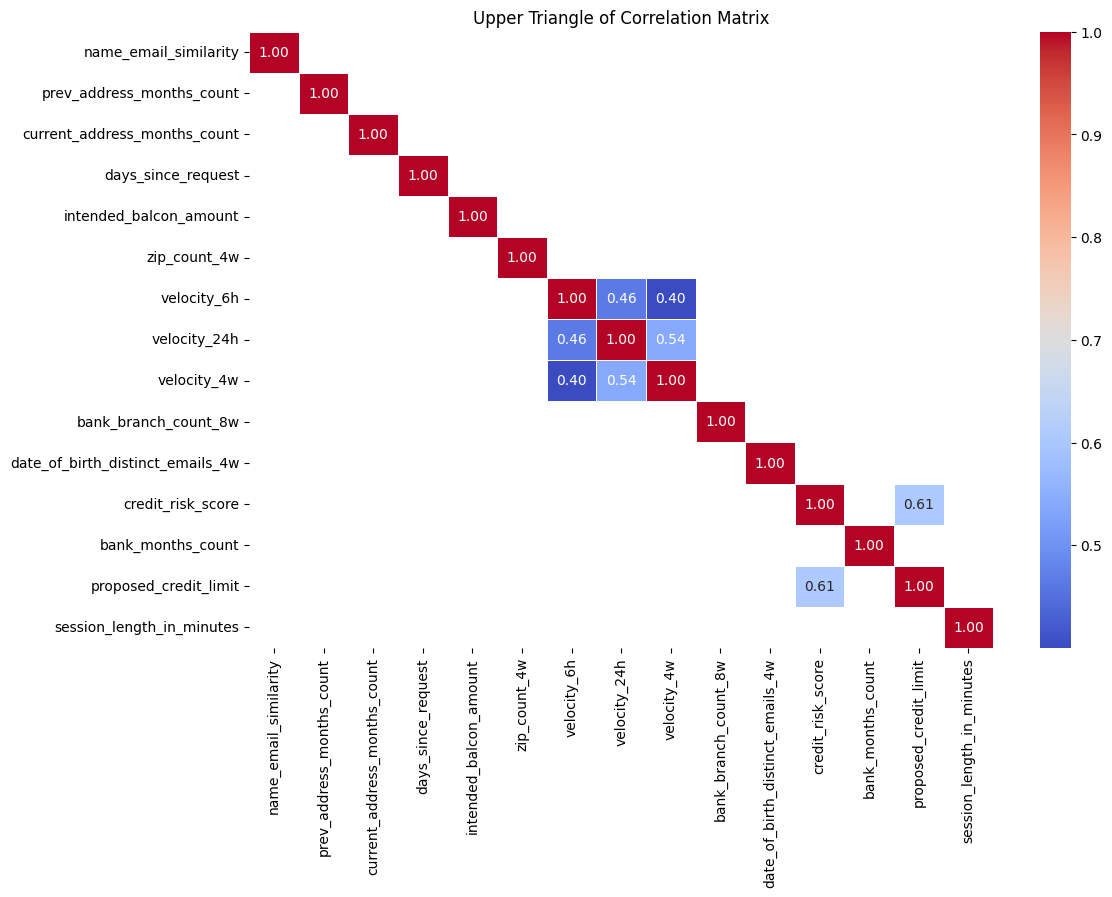

In [18]:
corr_matrix = df[numerical].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[(corr_matrix >= 0.4) | (corr_matrix <= -0.4)], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Upper Triangle of Correlation Matrix")
plt.show()